<font size="6"><b>MLP Neural Networks - Part II</b></font>

# Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

import datetime, warnings, scipy
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout , BatchNormalization
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras

# Data Loading

In [2]:
dfm_ready = pd.read_csv('dfm_ready.csv', index_col=0)
dfm_ready.head().append(dfm_ready.tail())

,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,15.0,3,3,10.0,-23.0,268.0,225.0,1605.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,2,3,7.0,-24.0,99.0,65.0,414.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,3,3,5.0,-13.0,134.0,106.0,846.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,3,3,6.0,-2.0,190.0,157.0,1120.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,-3.0,14.0,2,2,6.0,-16.0,206.0,173.0,1222.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7213439,31.0,12.0,4,4,6.0,9.0,182.0,142.0,1303.0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213440,-1.0,12.0,3,3,4.0,-23.0,84.0,46.0,331.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213441,-4.0,20.0,3,3,7.0,-5.0,100.0,72.0,331.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213442,6.0,18.0,4,4,10.0,1.0,181.0,148.0,936.0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213445,8.0,8.0,3,3,7.0,-4.0,71.0,44.0,130.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


The next cell will make sure that all my features are in floating format, followed by a double check with the .info() function

In [3]:
dfm_ready.drop(['TAXI_OUT','WHEELS_OFF','WHEELS_ON','DAY','TAXI_IN','ARR_DELAY'], axis=1, inplace=True)

In [4]:
df = dfm_ready.astype(float)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982067 entries, 0 to 7213445
Data columns (total 64 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   DEP_DELAY                      float64
 1   CRS_ELAPSED_TIME               float64
 2   AIR_TIME                       float64
 3   DISTANCE                       float64
 4   FLIGHT_STATUS                  float64
 5   OP_CARRIER_Allegiant Air       float64
 6   OP_CARRIER_American Airlines   float64
 7   OP_CARRIER_Delta Airlines      float64
 8   OP_CARRIER_Endeavor Air        float64
 9   OP_CARRIER_Envoy Air           float64
 10  OP_CARRIER_ExpressJet          float64
 11  OP_CARRIER_Frontier Airlines   float64
 12  OP_CARRIER_Hawaiian Airlines   float64
 13  OP_CARRIER_JetBlue Airways     float64
 14  OP_CARRIER_Mesa Airline        float64
 15  OP_CARRIER_PSA Airlines        float64
 16  OP_CARRIER_Republic Airways    float64
 17  OP_CARRIER_SkyWest Airlines    float64
 18  OP

==================================================================================

# Function Library

This is a quick parenthesis to write down a few functions that I will be using to evaluate every model once finish training it. 

In [6]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('LOSS', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('ACCURACY', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.show()

In [7]:
def conf_matrix(conf_mat):
    
    conf_mat = pd.DataFrame(conf_mat, index = ['0', '1'], columns = ['0', '1'])
    sns.set(font_scale=1.4)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_mat, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()


In [8]:
def model_metrics(a, b):
    
    accuracy = metrics.accuracy_score(a, b)
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)

    print('Accuracy:', round(accuracy*100, 2),'%')
    print('Precision score:', round(precision*100, 2),'%')
    print('Recall score:', round(recall*100, 2),'%')
    print('F1 score:', round(f1*100, 2),'%')

==================================================================================

<b>Target (y) and Features (X) definitions:</b>

The first model of this Notebook will have only the FLIGHT_STATUS (target) dropped from the input data. The reason for this is to be able to compare the accuracy and other metrics with the other models which will have the DEP_DELAY and all the MONTHS dropped as well. The months have been dropped following a feature selection done, which suggested that the months would not affect the model and by looking at the plots on the EDA, this is clear as there are no real trends or patterns with the months

In [9]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS'], axis=1)

# Neural Network Conditions

1. Data has to be purely numerical<br>
2. Data cannot contain missing values<br>
3. Data has to be Normalized<br>

In [10]:
df.isna().sum().sum()

0

We know the data is purely numerical and that it has no missing values, now all is needed is to normalized and we will do it by using the <b>StandardScaler</b>

In [11]:
col_names = list(df.columns)

s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

In [12]:
df_s.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-0.321391,1.529193,1.414654,1.172975,-0.768317,-0.050067,-0.436987,-0.444443,-0.181004,-0.187551,-0.160379,-0.127262,-0.036521,-0.213085,-0.160239,-0.185638,-0.21801,-0.331799,-0.408159,-0.164808,2.836956,-0.058718,-0.32781,-0.193782,-0.243678,-0.337531,-0.270339,4.024041,-0.201662,-0.246484,-0.203853,-0.241257,-0.202764,-0.279531,-0.189913,-0.188279,-0.17047,-0.212175,-0.170563,-0.212592,-0.19016,-0.789857,1.318873,-0.469791,-0.677184,1.357611,-0.666194,-0.279091,-0.301801,-0.301174,-0.307043,-0.308123,-0.312796,-0.31331,-0.298723,-0.307682,-0.297409,-0.298946,-0.409881,-0.411999,-0.417128,-0.418755,-0.371965,-0.405741
1,-0.384870,-0.705450,-0.755912,-0.730105,-0.768317,-0.050067,-0.436987,-0.444443,-0.181004,-0.187551,-0.160379,-0.127262,-0.036521,-0.213085,-0.160239,-0.185638,-0.21801,-0.331799,-0.408159,-0.164808,2.836956,-0.058718,-0.32781,-0.193782,-0.243678,-0.337531,-0.270339,-0.248506,-0.201662,-0.246484,-0.203853,-0.241257,-0.202764,-0.279531,-0.189913,-0.188279,-0.17047,-0.212175,-0.170563,4.703843,-0.19016,1.266053,-0.758223,-0.469791,-0.677184,1.357611,-0.666194,-0.279091,-0.301801,-0.301174,-0.307043,-0.308123,-0.312796,-0.31331,-0.298723,-0.307682,-0.297409,-0.298946,-0.409881,-0.411999,-0.417128,-0.418755,-0.371965,-0.405741


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Modeling

## Model 1

In [14]:
model_1 = Sequential()

model_1.add(Dense(50, activation='relu', input_shape=(63,)))

model_1.add(Dense(30, activation='relu'))

model_1.add(Dense(10, activation='relu'))

model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3200      
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


In [25]:
!conda install graphviz

^C


In [22]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model_1, title="Model 1")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs

In [15]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
results1 = model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
83997/83997 [==============================] - 115s 1ms/step - loss: 0.3432 - accuracy: 0.8580 - val_loss: 0.3260 - val_accuracy: 0.8645
Epoch 2/10
83997/83997 [==============================] - 109s 1ms/step - loss: 0.3276 - accuracy: 0.8636 - val_loss: 0.3209 - val_accuracy: 0.8667
Epoch 3/10
83997/83997 [==============================] - 131s 2ms/step - loss: 0.3258 - accuracy: 0.8646 - val_loss: 0.3205 - val_accuracy: 0.8670
Epoch 4/10
83997/83997 [==============================] - 135s 2ms/step - loss: 0.3249 - accuracy: 0.8650 - val_loss: 0.3273 - val_accuracy: 0.8636
Epoch 5/10
83997/83997 [==============================] - 135s 2ms/step - loss: 0.3242 - accuracy: 0.8653 - val_loss: 0.3225 - val_accuracy: 0.8656
Epoch 6/10
83997/83997 [==============================] - 136s 2ms/step - loss: 0.3236 - accuracy: 0.8656 - val_loss: 0.3249 - val_accuracy: 0.8630
Epoch 7/10
83997/83997 [==============================] - 104s 1ms/step - loss: 0.3231 - accuracy: 0.8658 - val_

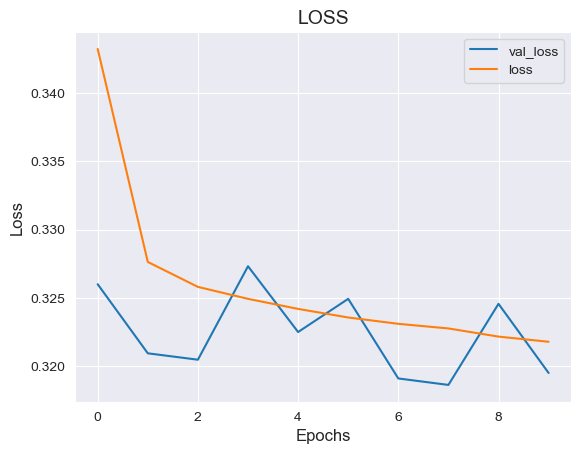

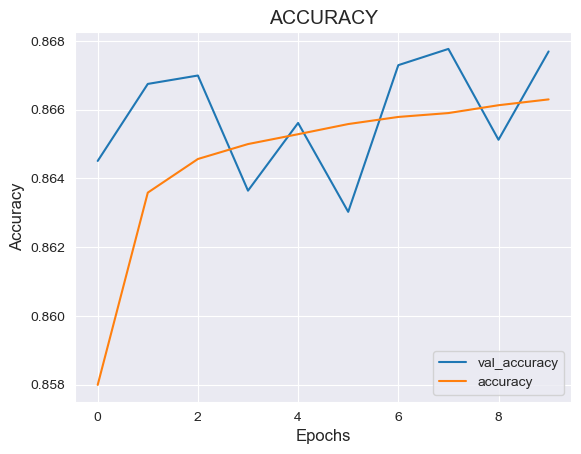

In [17]:
visualize_training_results(results1)

In [18]:
y_pred_m1 = model_1.predict(X_test)
y_pred_m1 =(y_pred_m1 > 0.5)

31110/31110 [==============================] - 18s 568us/step


In [19]:
cm_m1 = confusion_matrix(y_test, y_pred_m1)
print(cm_m1)
print("------------------")
print(classification_report(y_test, y_pred_m1))

[[601485  24560]
 [107286 262186]]
------------------
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90    626045
         1.0       0.91      0.71      0.80    369472

    accuracy                           0.87    995517
   macro avg       0.88      0.84      0.85    995517
weighted avg       0.87      0.87      0.86    995517



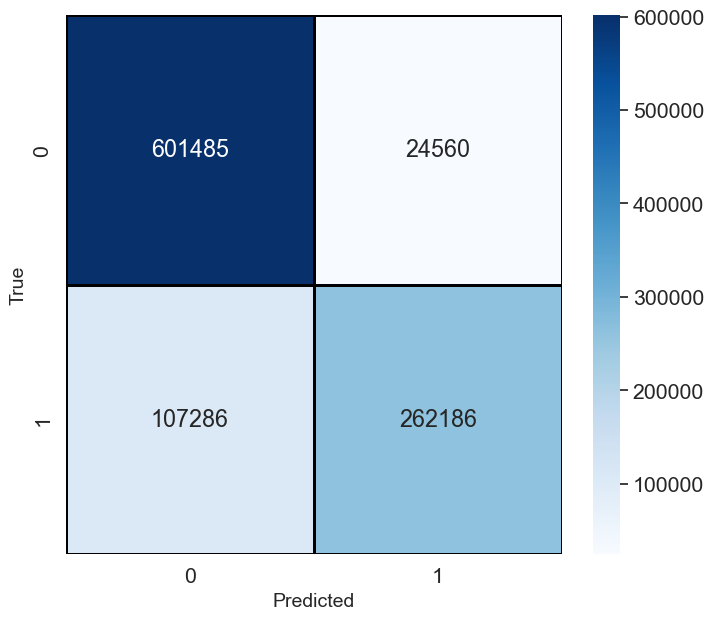

In [20]:
conf_matrix(cm_m1)

In [21]:
model_metrics(y_test, y_pred_m1)

Accuracy: 86.76 %
Precision score: 91.43 %
Recall score: 70.96 %
F1 score: 79.91 %


=========================================================================================

<b>FROM HERE ONWARDS THE MODELS HAVE A DIFFERENT SET OF FEATURES WITH ALL THE MONTHS BEING DROPPED. AFTER DOING A FEATURE SELECTION IT WAS CLEAR THAT THESE WOULD NOT HAVE ANY RELEVANCE IN THE MODEL AND THEREFORE WOULD CAUSE NOISE. 

=========================================================================================

In [22]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS', 'DEP_DELAY', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'], axis=1)

## Model 2

In [23]:
model_2 = Sequential()

model_2.add(Dense(50, activation='relu', input_shape=(63,)))

model_2.add(Dense(30, activation='relu'))

model_2.add(Dense(10, activation='relu'))

model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                3200      
                                                                 
 dense_5 (Dense)             (None, 30)                1530      
                                                                 
 dense_6 (Dense)             (None, 10)                310       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
results2 = model_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
83997/83997 [==============================] - 75s 889us/step - loss: 0.3393 - accuracy: 0.8588 - val_loss: 0.3335 - val_accuracy: 0.8593
Epoch 2/10
83997/83997 [==============================] - 72s 855us/step - loss: 0.3276 - accuracy: 0.8639 - val_loss: 0.3253 - val_accuracy: 0.8634
Epoch 3/10
83997/83997 [==============================] - 73s 875us/step - loss: 0.3257 - accuracy: 0.8647 - val_loss: 0.3204 - val_accuracy: 0.8675
Epoch 4/10
83997/83997 [==============================] - 74s 876us/step - loss: 0.3245 - accuracy: 0.8651 - val_loss: 0.3278 - val_accuracy: 0.8655
Epoch 5/10
83997/83997 [==============================] - 73s 866us/step - loss: 0.3236 - accuracy: 0.8656 - val_loss: 0.3197 - val_accuracy: 0.8680
Epoch 6/10
83997/83997 [==============================] - 73s 869us/step - loss: 0.3230 - accuracy: 0.8658 - val_loss: 0.3210 - val_accuracy: 0.8676
Epoch 7/10
83997/83997 [==============================] - 76s 900us/step - loss: 0.3225 - accuracy: 0.8660

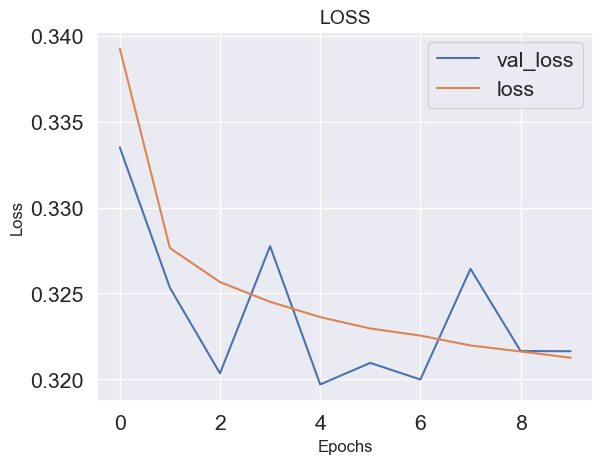

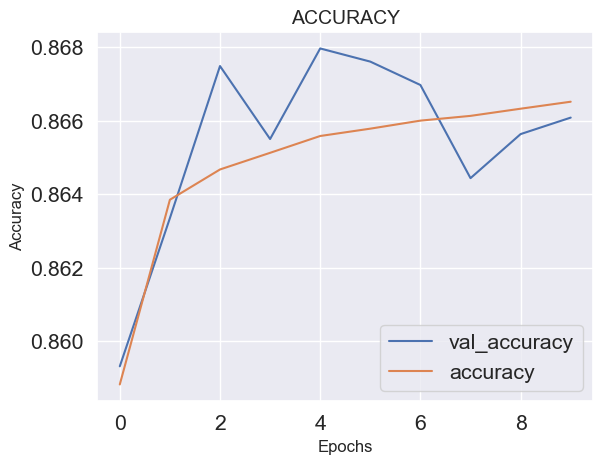

In [26]:
visualize_training_results(results2)

In [27]:
y_pred_m2 = model_2.predict(X_test)
y_pred_m2 =(y_pred_m2 > 0.5)

31110/31110 [==============================] - 18s 572us/step


In [28]:
cm_m2 = confusion_matrix(y_test, y_pred_m2)
print(cm_m2)
print("------------------")
print(classification_report(y_test, y_pred_m2))

[[605166  20879]
 [112691 256781]]
------------------
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90    626045
         1.0       0.92      0.69      0.79    369472

    accuracy                           0.87    995517
   macro avg       0.88      0.83      0.85    995517
weighted avg       0.87      0.87      0.86    995517



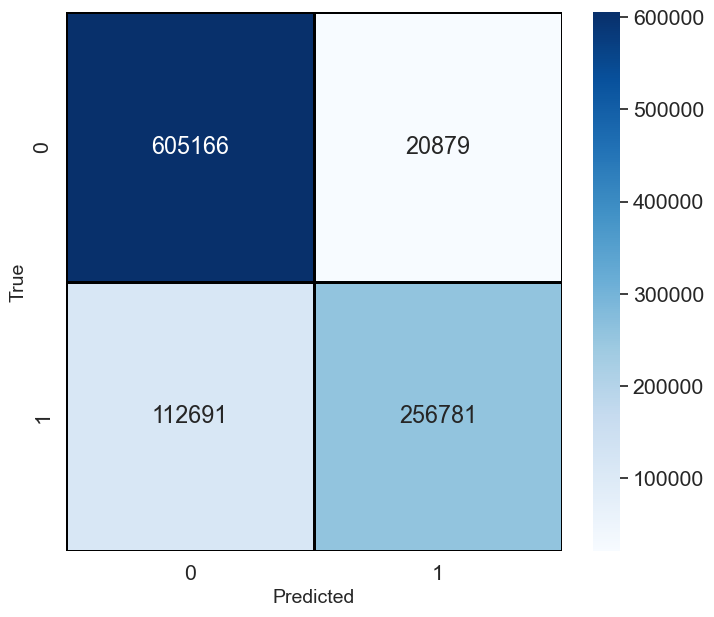

In [29]:
conf_matrix(cm_m2)

In [30]:
model_metrics(y_test, y_pred_m2)

Accuracy: 86.58 %
Precision score: 92.48 %
Recall score: 69.5 %
F1 score: 79.36 %


=========================================================================================

=========================================================================================

## Model 3

In [31]:
model_3 = Sequential()

model_3.add(Dense(50, activation='relu', input_shape=(63,)))

model_3.add(Dense(30, activation='relu'))

model_3.add(Dense(15, activation='relu'))

model_3.add(Dense(5, activation='relu'))

model_3.add(Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                3200      
                                                                 
 dense_9 (Dense)             (None, 30)                1530      
                                                                 
 dense_10 (Dense)            (None, 15)                465       
                                                                 
 dense_11 (Dense)            (None, 5)                 80        
                                                                 
 dense_12 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
results3 = model_3.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
83997/83997 [==============================] - 77s 910us/step - loss: 0.3497 - accuracy: 0.8576 - val_loss: 0.3274 - val_accuracy: 0.8648
Epoch 2/2
83997/83997 [==============================] - 76s 903us/step - loss: 0.3281 - accuracy: 0.8636 - val_loss: 0.3240 - val_accuracy: 0.8660


In [36]:
y_pred_m3 = model_3.predict(X_test)
y_pred_m3 =(y_pred_m3>0.5)

31110/31110 [==============================] - 18s 582us/step


In [37]:
cm_m3 = confusion_matrix(y_test, y_pred_m3)
print(cm_m3)
print("------------------")
print(classification_report(y_test, y_pred_m3))

[[595805  30240]
 [103002 266470]]
------------------
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90    626045
         1.0       0.90      0.72      0.80    369472

    accuracy                           0.87    995517
   macro avg       0.88      0.84      0.85    995517
weighted avg       0.87      0.87      0.86    995517



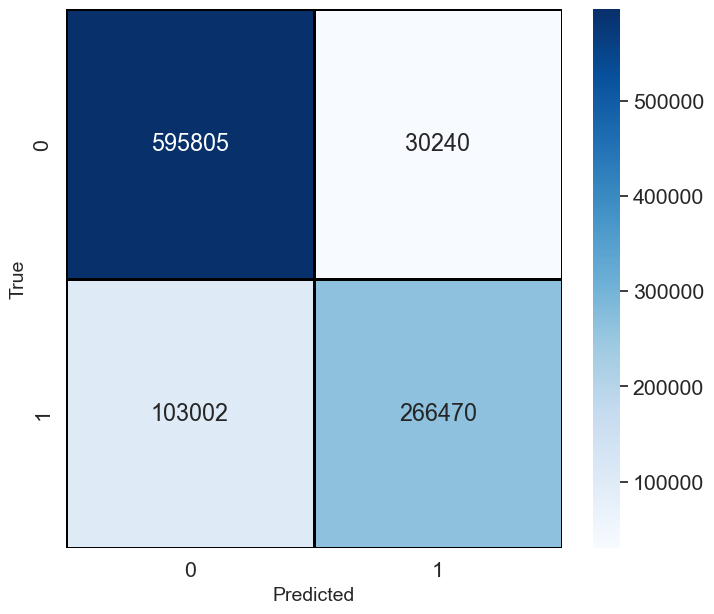

In [38]:
conf_matrix(cm_m3)

In [39]:
model_metrics(y_test, y_pred_m3)

Accuracy: 86.62 %
Precision score: 89.81 %
Recall score: 72.12 %
F1 score: 80.0 %


=========================================================================================

=========================================================================================

## Model 4

In [40]:
model_4 = Sequential()

model_4.add(Dense(50, activation='tanh', input_shape=(63,)))

model_4.add(Dense(30, activation='tanh'))

model_4.add(Dense(15, activation='tanh'))

model_4.add(Dense(5, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 50)                3200      
                                                                 
 dense_14 (Dense)            (None, 30)                1530      
                                                                 
 dense_15 (Dense)            (None, 15)                465       
                                                                 
 dense_16 (Dense)            (None, 5)                 80        
                                                                 
 dense_17 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
results4 = model_4.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
83997/83997 [==============================] - 75s 885us/step - loss: 0.3660 - accuracy: 0.8532 - val_loss: 0.3557 - val_accuracy: 0.8559
Epoch 2/2
83997/83997 [==============================] - 75s 896us/step - loss: 0.3513 - accuracy: 0.8571 - val_loss: 0.3385 - val_accuracy: 0.8644


In [43]:
y_pred_m4 = model_4.predict(X_test)
y_pred_m4 =(y_pred_m4>0.5)

31110/31110 [==============================] - 19s 599us/step


In [44]:
cm_m4 = confusion_matrix(y_test, y_pred_m4)
print(cm_m4)
print("------------------")
print(classification_report(y_test, y_pred_m4))

[[590947  35098]
 [ 99582 269890]]
------------------
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90    626045
         1.0       0.88      0.73      0.80    369472

    accuracy                           0.86    995517
   macro avg       0.87      0.84      0.85    995517
weighted avg       0.87      0.86      0.86    995517



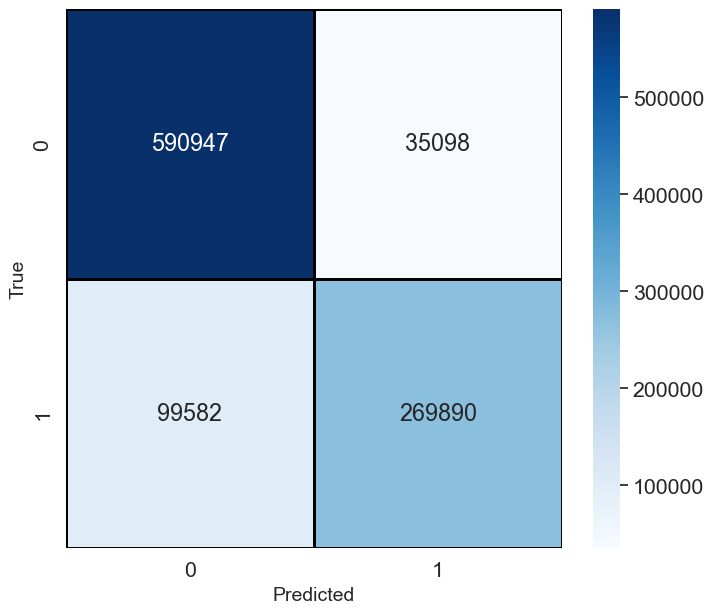

In [45]:
conf_matrix(cm_m4)

In [46]:
model_metrics(y_test, y_pred_m4)

Accuracy: 86.47 %
Precision score: 88.49 %
Recall score: 73.05 %
F1 score: 80.03 %


=========================================================================================

=========================================================================================

## Model 5

In [47]:
model_5 = Sequential()

model_5.add(Dense(50, activation='tanh', input_shape=(63,)))

model_5.add(Dense(30, activation='tanh'))

model_5.add(Dense(15, activation='tanh'))

model_5.add(Dense(5, activation='relu'))

model_5.add(Dense(1, activation='sigmoid'))

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 50)                3200      
                                                                 
 dense_19 (Dense)            (None, 30)                1530      
                                                                 
 dense_20 (Dense)            (None, 15)                465       
                                                                 
 dense_21 (Dense)            (None, 5)                 80        
                                                                 
 dense_22 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
results5 = model_5.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
83997/83997 [==============================] - 76s 893us/step - loss: 0.3601 - accuracy: 0.8528 - val_loss: 0.3693 - val_accuracy: 0.8450
Epoch 2/25
83997/83997 [==============================] - 75s 892us/step - loss: 0.3513 - accuracy: 0.8564 - val_loss: 0.3470 - val_accuracy: 0.8556
Epoch 3/25
83997/83997 [==============================] - 77s 921us/step - loss: 0.3496 - accuracy: 0.8569 - val_loss: 0.3373 - val_accuracy: 0.8625
Epoch 4/25
83997/83997 [==============================] - 78s 926us/step - loss: 0.3487 - accuracy: 0.8569 - val_loss: 0.3571 - val_accuracy: 0.8497
Epoch 5/25
83997/83997 [==============================] - 78s 929us/step - loss: 0.3478 - accuracy: 0.8565 - val_loss: 0.3451 - val_accuracy: 0.8534
Epoch 6/25
83997/83997 [==============================] - 78s 928us/step - loss: 0.3451 - accuracy: 0.8572 - val_loss: 0.3388 - val_accuracy: 0.8615
Epoch 7/25
83997/83997 [==============================] - 78s 932us/step - loss: 0.3454 - accuracy: 0.8575

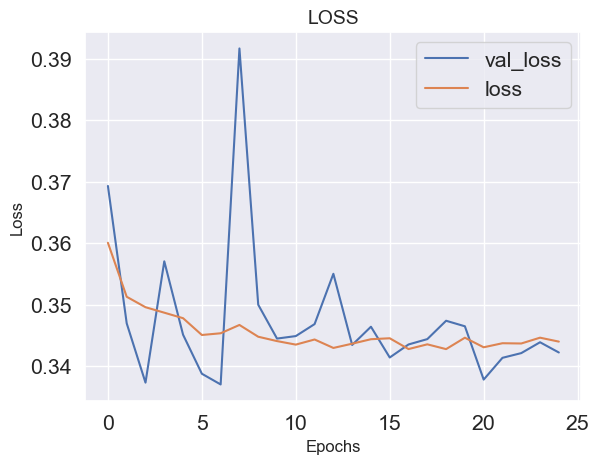

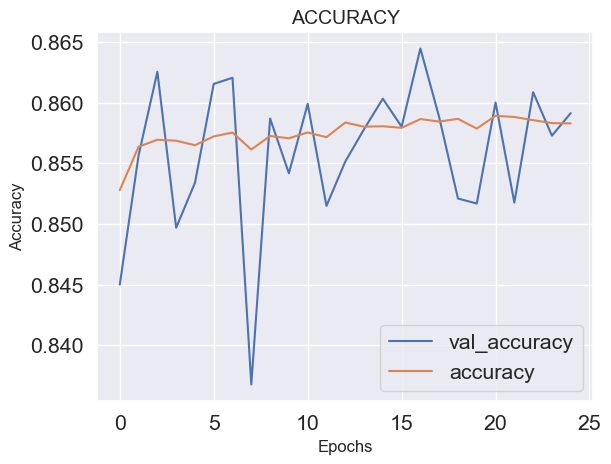

In [50]:
visualize_training_results(results5)

In [51]:
y_pred_m5 = model_5.predict(X_test)
y_pred_m5 =(y_pred_m5 > 0.5)

31110/31110 [==============================] - 18s 582us/step


In [52]:
cm_m5 = confusion_matrix(y_test, y_pred_m5)
print(cm_m5)
print("------------------")
print(classification_report(y_test, y_pred_m5))

[[582213  43832]
 [ 96163 273309]]
------------------
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89    626045
         1.0       0.86      0.74      0.80    369472

    accuracy                           0.86    995517
   macro avg       0.86      0.83      0.84    995517
weighted avg       0.86      0.86      0.86    995517



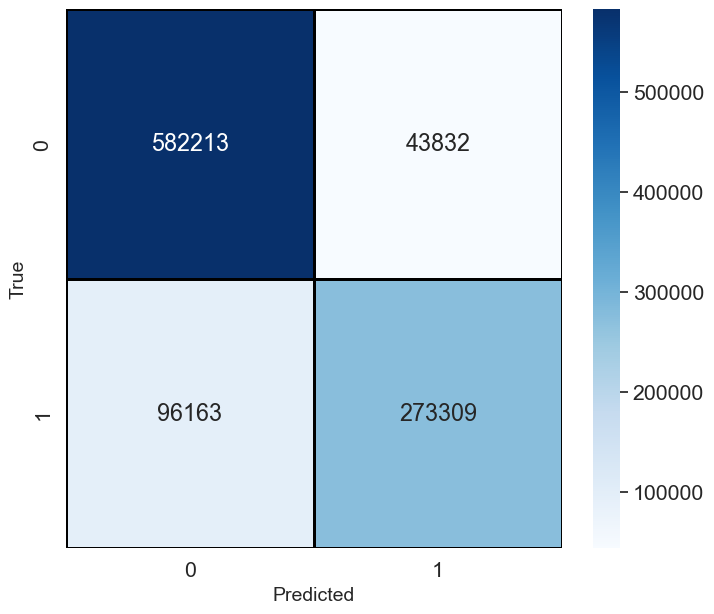

In [53]:
conf_matrix(cm_m5)

In [54]:
model_metrics(y_test, y_pred_m5)

Accuracy: 85.94 %
Precision score: 86.18 %
Recall score: 73.97 %
F1 score: 79.61 %


=========================================================================================

=========================================================================================

## Model 6

In [55]:
model_6 = Sequential()

model_6.add(Dense(50, activation='tanh', input_shape=(63,)))

model_6.add(Dense(40, activation='relu'))

model_6.add(Dense(30, activation='tanh'))

model_6.add(Dense(10, activation='relu'))

model_6.add(Dense(5, activation='relu'))

model_6.add(Dense(1, activation='sigmoid'))

model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 50)                3200      
                                                                 
 dense_24 (Dense)            (None, 40)                2040      
                                                                 
 dense_25 (Dense)            (None, 30)                1230      
                                                                 
 dense_26 (Dense)            (None, 10)                310       
                                                                 
 dense_27 (Dense)            (None, 5)                 55        
                                                                 
 dense_28 (Dense)            (None, 1)                 6         
                                                                 
Total params: 6,841
Trainable params: 6,841
Non-traina

In [56]:
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
results6 = model_6.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=0.1)

Epoch 1/2
268790/268790 [==============================] - 238s 884us/step - loss: 0.3830 - accuracy: 0.8421 - val_loss: 0.3899 - val_accuracy: 0.8014
Epoch 2/2
268790/268790 [==============================] - 238s 885us/step - loss: 0.3779 - accuracy: 0.8432 - val_loss: 0.3550 - val_accuracy: 0.8612


No need for the visualizations because of the low epoch number. This was just a parameters test.

In [58]:
eval_model = model_6.evaluate(X_train, y_train)
eval_model

93330/93330 [==============================] - 61s 656us/step - loss: 0.3549 - accuracy: 0.8609


[0.35490259528160095, 0.8609288334846497]

In [59]:
y_pred_m6 = model_6.predict(X_test)
y_pred_m6 =(y_pred_m6>0.5)

31110/31110 [==============================] - 18s 576us/step


In [60]:
cm_m6 = confusion_matrix(y_test, y_pred_m6)
print(cm_m6)
print("------------------")
print(classification_report(y_test, y_pred_m6))

[[607015  19030]
 [119568 249904]]
------------------
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90    626045
         1.0       0.93      0.68      0.78    369472

    accuracy                           0.86    995517
   macro avg       0.88      0.82      0.84    995517
weighted avg       0.87      0.86      0.85    995517



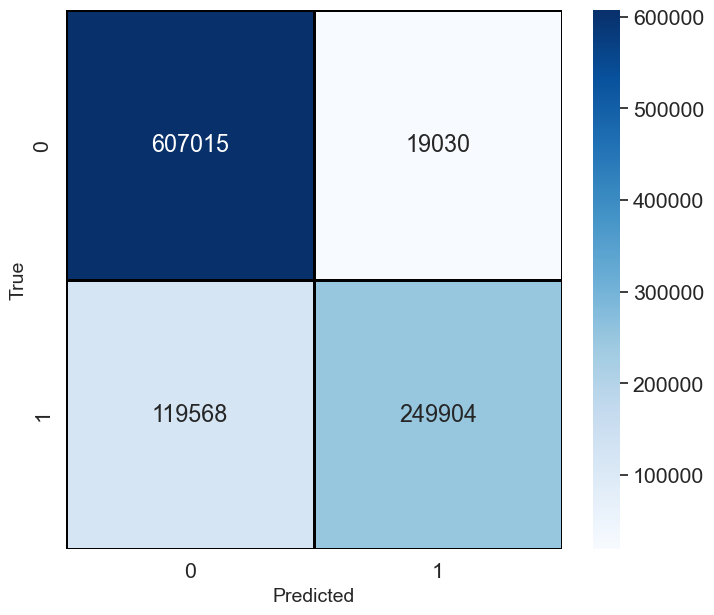

In [61]:
conf_matrix(cm_m6)

In [63]:
model_metrics(y_test, y_pred_m6)

Accuracy: 86.08 %
Precision score: 92.92 %
Recall score: 67.64 %
F1 score: 78.29 %


## Model 7

In [ ]:
model_7 = Sequential()

model_7.add(Dense(50, activation='tanh', input_shape=(63,)))

model_7.add(Dense(30, activation='tanh'))

model_7.add(Dense(15, activation='tanh'))

model_7.add(Dense(5, activation='relu'))

model_7.add(Dense(1, activation='sigmoid'))

model_7.summary()

In [ ]:
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])